In [1]:
import numpy as np
import os
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

### 数据集读取
- Mnist数据是图像数据：(28,28,1)的灰度图

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
mnist

{'data':        pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
 0         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 1         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 2         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 3         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 4         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 ...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
 69995     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69996     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69997     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69998     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69999     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 
      

In [3]:
X, y = mnist["data"], mnist["target"]

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [28]:
# 洗牌操作
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train.iloc[shuffle_index], y_train.iloc[shuffle_index]

In [29]:
y_train

9158     0
8773     3
36660    6
55455    5
16820    8
        ..
9031     2
36592    3
3282     7
29704    0
42753    5
Name: class, Length: 60000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

### 交叉验证

In [36]:
y_train_5 = (y_train=='5')
y_test_5 = (y_test=='5')

In [37]:
y_train_5[:10]

9158     False
8773     False
36660    False
55455     True
16820    False
7863     False
31844    False
51100    False
29348     True
47209    False
Name: class, dtype: bool

In [38]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5)  # 分类器

SGDClassifier(max_iter=5, random_state=42)

In [44]:
sgd_clf.predict([X.iloc[35000]])

array([False])

In [40]:
y[35000]

'1'

In [45]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9411 , 0.89325, 0.93815])

In [48]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone  # 克隆

skflods = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
for train_index, test_index in skflods.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_folds = X_train.iloc[test_index]
    y_test_folds = y_train_5.iloc[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct/len(y_pred))

0.96695
0.9442
0.9679


### Confusion Matrix-混淆矩阵

In [49]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [50]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[50654,  3925],
       [  625,  4796]], dtype=int64)

negative class  [[ **true negatives** , **false positives** ],
 
positive class  [ **false negatives** , **true positives** ]]

* true negatives:  53,272个数据被正确的分为非5类别
* false positives：1307张被错误的分为5类别

* false negatives：1077张错误的分为非5类别
* true positives： 4344张被正确的分为5类别

一个完美的分类器应该只有**true positives** 和 **true negatives**, 即主对角线元素不为0，其余元素为0

In [51]:
from sklearn.metrics import precision_score,recall_score
precision_score(y_train_5,y_train_pred)

0.5499369338378627

In [52]:
recall_score(y_train_5,y_train_pred)

0.8847076185205681

In [53]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.678263329090652

### 阈值对结果的影响

In [55]:
y_scores = sgd_clf.decision_function([X.iloc[35000]])  # 返回预测得分值
y_scores

array([-253244.36337694])

In [58]:
t = 0
y_pred = (y_scores > t)
y_pred

array([False])

In [59]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [60]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

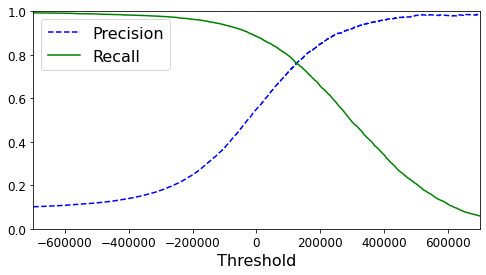

In [61]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,
             precisions[:-1],
            "b--",
            label="Precision")
    
    plt.plot(thresholds,
             recalls[:-1],
            "g-",
            label="Recall")
    plt.xlabel("Threshold",fontsize=16)
    plt.legend(loc="upper left",fontsize=16)
    plt.ylim([0,1])
    
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.xlim([-700000, 700000])
plt.show()

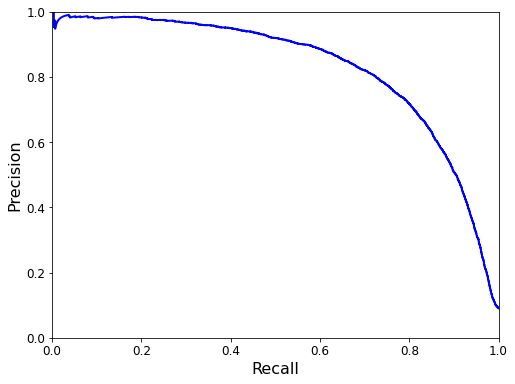

In [62]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, 
             precisions, 
             "b-", 
             linewidth=2)
    
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

### ROC curves
**receiver operating characteristic (ROC)** 曲线是二元分类中的常用评估方法
* 它与精确度/召回曲线非常相似，但ROC曲线不是绘制精确度与召回率，而是绘制**true positive rate(TPR)** 与**false positive rate(FPR)** 

* 要绘制ROC曲线，首先需要使用**roc_curve（）**函数计算各种阈值的**TPR和FPR**：

TPR = TP / (TP + FN) (Recall)

FPR = FP / (FP + TN)

In [63]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

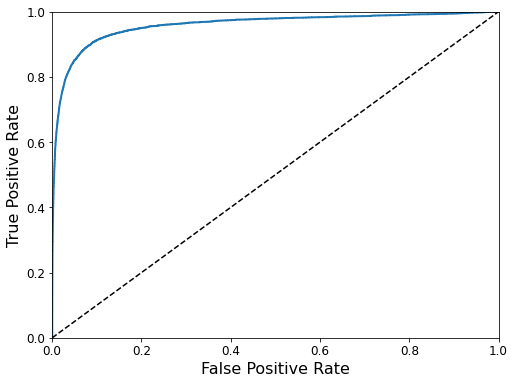

In [64]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

**虚线表示纯随机分类器的ROC曲线**; 一个好的分类器尽可能远离该线（朝左上角）。

比较分类器的一种方法是测量曲线下面积（AUC）。完美分类器的ROC AUC**等于1**，而纯随机分类器的ROC AUC**等于0.5**。 Scikit-Learn提供了计算ROC AUC的函数：

In [65]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.958720836479576